In [1]:
import jupyter

# Comparação por scaler
| Scaler               | Train (↓ melhor) | Test (↓ melhor) | Comentário                     |
| -------------------- | ---------------- | --------------- | ------------------------------ |
| **PowerTransformer** | **0.0058**       | **0.0354**      | 🔥 Melhor separabilidade geral |
| QuantileTransformer  | 0.0112           | 0.0380          | Bom em geral                   |
| StandardScaler       | 0.0115           | 0.0375          | Similar ao Quantile            |
| RobustScaler         | 0.0119           | 0.0464          | Um pouco pior em teste         |
| **MinMaxScaler**     | 0.0260           | **0.0664**      | 🚫 Fraca generalização         |
| **MaxAbsScaler**     | **0.0444**       | 0.0524          | 🚫 Muito fraco                 |


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from src.utils.system import boot
from src.defaults import TOP2_STOCK_BY_SECTOR, RANDOM_SEEDS
from src.data.feature_pipeline import load_base_dataframe

DEVICE = boot()
OHLCV_DF = load_base_dataframe()

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
from hurst import compute_Hc
from pyts.image import RecurrencePlot
import datetime

# PROJECT SETUP ==================================
TICKERS         = TOP2_STOCK_BY_SECTOR
#TICKERS = OHLCV_DF['symbol'].unique()
#TICKERS = TOP2_STOCK_BY_SECTOR 

CHAOS_THRESHOLD = 0.45
WINDOW_SIZE     = 120
ENTROPY_BINS    = 10
N_WEEK_DAYS     = 5
STEP_SIZE       = 20
MAX_LEN         = 64
LOOKBACK_BUFFER = 40
ROLLING_WINDOW  = 5
START_DATE      = "2023-01-01",
END_DATE        = "2025-05-01"#pd.Timestamp.today().replace(day=1)
TRAIN_MONTHS    = 2
TEST_MONTHS     = 1
MIN_WINDOW_DAYS = 20
NUM_EPOCHS      = 1
SEEDS = RANDOM_SEEDS[:5]

""" 
DEVELOPER NOTES:
@todo : onehot encode day_of_week so the Model wont use the data as a sized sequence 
"""
BASIC_FEATURES=[
    "close"	,          # Core price for reward and trend awareness
    "volume",          # Volume for activity level
    "candle_body",     # Price strength (close-open)
    "upper_shadow",    # Wick size = volatility / exhaustion
    "lower_shadow",    # Same as above
    "order_flow",      # Flow = pressure indicator (buy/sell imbalance)
    "price_change",    # Price momentum short term
    "volatility",      # Recent price dispersion
    "momentum",        # Rolling price trend
    "vix_norm",        # Implied market risk normalized
    "market_return_1d",# Market regime alignment
    "day_of_week"      # heard it's important                
]

# That’s 12 columns, enough to:
# * See price movement
# * Detect regime shifts
# * Respond to risk

# Second Round:
# * overnight_price_change → if overnight gaps matter to your strategy
# * trade_count_change → intraday activity shifts
# * sp500_norm → macro regime normalization

DEFAULT_INTERNAL_FEATURES = [
    "position",
    "holding_period",
    "cumulative_reward",
    "pct_time",
    "drawdown",
    "unrealized_pnl",
    "entry_price",
    "time_in_position",
    "prev_action"
]



# Data preparation

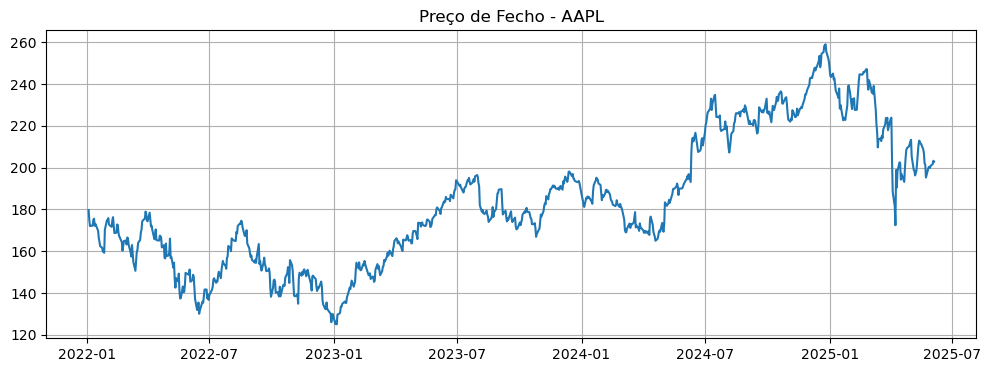

In [4]:
# STEP 1 - GET DATA =======================
# POC

EXPERIENCE_NAME="regime_detection_and_alignment__v2"

results_path = f"data/experiments/{EXPERIENCE_NAME}.csv"

TICKERS = TOP2_STOCK_BY_SECTOR
FEATURES =  ["volatility", "momentum", "kurtosis", "entropy", "adf_pvalue", "hurst"]
df = OHLCV_DF[OHLCV_DF['symbol'].isin(TICKERS)].copy()


#df = OHLCV_DF[OHLCV_DF['symbol'] == ticker].copy()

df = df.sort_values("date").reset_index(drop=True)




In [13]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler
from scipy.stats import f_oneway
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
import scipy.stats as stats
import ace_tools_open as tools

import random
import numpy as np

def set_global_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    
# ------------------------
# Regime Indicators (Causal)
# ------------------------
def compute_regime_indicators(df, window=30, hurst_window=128):
    df = df.copy()

    df["volatility"] = df["close"].shift(1).rolling(window).std()
    df["momentum"] = df["close"].pct_change(periods=window).shift(1)
    df["kurtosis"] = df["close"].shift(1).rolling(window).apply(lambda x: stats.kurtosis(x), raw=True)
    df["entropy"] = df["close"].shift(1).rolling(window).apply(
        lambda x: stats.entropy(np.histogram(x, bins=10)[0] + 1), raw=True
    )
    df["adf_pvalue"] = df["close"].shift(1).rolling(window).apply(
        lambda x: adfuller(x)[1] if len(x.dropna()) == window else np.nan
    )

    hurst_vals = []
    for i in range(len(df)):
        if i >= hurst_window:
            window_data = df["close"].iloc[i - hurst_window:i].dropna()
            try:
                hurst_val = compute_Hc(window_data.values, kind="price", simplified=True)[0]
            except:
                hurst_val = np.nan
        else:
            hurst_val = np.nan
        hurst_vals.append(hurst_val)
    df["hurst"] = hurst_vals

    return df

# ------------------------
# Regime Classifier
# ------------------------
def regime_classifier(df_ind, ticker, features, start_date, split_date, end_date, train_months, test_months, n_clusters,  scaler_class, seed=42,verbose=False, plot=False):
    df_clean = df_ind.dropna().copy()
    df_train = df_clean[(df_clean["date"] >= start_date) & (df_clean["date"] < split_date)].copy()
    df_test = df_clean[(df_clean["date"] >= split_date) & (df_clean["date"] <= end_date)].copy()

    if len(df_train) < 10 or len(df_test) < 10:
        return None

    if scaler_class.__name__ == "QuantileTransformer":
        scaler = QuantileTransformer(output_distribution="normal",random_state=seed)
    elif scaler_class.__name__ == "PowerTransformer":
        scaler = PowerTransformer(method="yeo-johnson")
    else:
        scaler = scaler_class()

    X_train = scaler.fit_transform(df_train[features])
    X_test = scaler.transform(df_test[features])

    kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
    df_train["regime"] = kmeans.fit_predict(X_train)
    df_test["regime"] = kmeans.predict(X_test)
    df_test["cluster_dist"] = kmeans.transform(X_test).min(axis=1)

    pvals_test = {}
    significant_count = 0
    for feat in features:
        groups = [df_test[df_test["regime"] == i][feat] for i in range(n_clusters) if (df_test["regime"] == i).shape[0] > 1]
        if len(groups) >= 2:
            _, pval = f_oneway(*groups)
            pvals_test[feat] = pval
            if pval < 0.05:
                significant_count += 1
        else:
            pvals_test[feat] = None

    result = {
        "ticker": ticker,
        "start_date": start_date,
        "split_date": split_date,
        "end_date": end_date,
        "n_clusters": n_clusters,
        "scaler_name": scaler_class.__name__,
        "train_size": len(df_train),
        "test_size": len(df_test),
        "train_months": train_months,
        "test_months": test_months,
        "seed":seed,
        "regime_train_dist": json.dumps(df_train["regime"].value_counts().to_dict(), sort_keys=True),
        "regime_test_dist": json.dumps(df_test["regime"].value_counts().to_dict(), sort_keys=True),
        "anova_significant_features_test": significant_count
    }

    avg_test_pvals = []
    for feat in features:
        result[f"pval_{feat}_test"] = pvals_test.get(feat)
        avg_test_pvals.append(pvals_test.get(feat))
    result["avg_pval_test"] = np.nanmean(avg_test_pvals)

    pvals_train = {}
    significant_count = 0
    for feat in features:
        groups = [df_train[df_train["regime"] == i][feat] for i in range(n_clusters) if (df_train["regime"] == i).shape[0] > 1]
        if len(groups) >= 2:
            _, pval = f_oneway(*groups)
            pvals_train[feat] = pval
            if pval < 0.05:
                significant_count += 1
        else:
            pvals_train[feat] = None

    avg_train_pvals = []
    for feat in features:
        result[f"pval_{feat}_train"] = pvals_train.get(feat)
        avg_train_pvals.append(pvals_train.get(feat))
    result["avg_pval_train"] = np.nanmean(avg_train_pvals)

    return result

# ------------------------
# Discretizer
# ------------------------
def discretize_result(result, thresholds={"anova_significant_features_test": [0, 2, 4, 6], "test_size": [0, 25, 50, 100]}):
    sig = result["anova_significant_features_test"]
    ts = result["test_size"]

    result["anova_strength"] = (
        "low" if sig < thresholds["anova_significant_features_test"][1] else
        "medium" if sig < thresholds["anova_significant_features_test"][2] else "high"
    )

    result["test_size_cat"] = (
        "tiny" if ts < thresholds["test_size"][1] else
        "small" if ts < thresholds["test_size"][2] else
        "medium" if ts < thresholds["test_size"][3] else "large"
    )

    return result

# ------------------------
# Walkforward Regime Classifier
# ------------------------
def walkforward_refime_classifier(
    df, tickers, results_path, features,
    start_date="2023-01-01",
    train_months=5, test_months=5,
    n_clusters=3,
    seeds=[42],
    scalers=[QuantileTransformer, PowerTransformer, MaxAbsScaler, MinMaxScaler, StandardScaler, RobustScaler]
):
    for ticker in tickers:
        df_ticker = df[df["symbol"] == ticker].copy().sort_values("date").reset_index(drop=True)
        df_ticker = compute_regime_indicators(df_ticker)

        start = pd.to_datetime(start_date)
        end = df_ticker["date"].max() - relativedelta(months=train_months + test_months)

        if os.path.exists(results_path):
            cached_results = pd.read_csv(results_path)
            cached_results = cached_results.fillna("None")
            cached_results["start_date"] = pd.to_datetime(cached_results["start_date"]).dt.date.astype(str)
            cached_results["split_date"] = pd.to_datetime(cached_results["split_date"]).dt.date.astype(str)
            cached_results["end_date"] = pd.to_datetime(cached_results["end_date"]).dt.date.astype(str)
            monthly_results = cached_results.to_dict("records")
        else:
            monthly_results = []

        while start < end:
            split = start + relativedelta(months=train_months)
            test_end = split + relativedelta(months=test_months)

            for scaler in scalers:
                for seed in seeds:
                    set_global_seed(seed)

                    # Avoid recomputation
                    if any(
                        r["ticker"] == ticker and
                        r["start_date"] == str(start.date()) and
                        r["split_date"] == str(split.date()) and
                        r["end_date"] == str(test_end.date()) and
                        r["n_clusters"] == n_clusters and
                        r["scaler_name"] == scaler.__name__ and
                        int(r.get("seed", -1)) == seed
                        for r in monthly_results
                    ):
                        continue

                    # Run classifier
                    result = regime_classifier(
                        df_ticker, ticker, features,
                        start_date=str(start.date()),
                        split_date=str(split.date()),
                        end_date=str(test_end.date()),
                        train_months=train_months,
                        test_months=test_months,
                        n_clusters=n_clusters,
                        seed=seed,
                        scaler_class=scaler
                    )

                    if result:
                        result = discretize_result(result)
                        monthly_results.append(result)

            start += relativedelta(months=1)

        results_df = pd.DataFrame(monthly_results)
        results_df.to_csv(results_path, index=False)
        tools.display_dataframe_to_user(name="Regime Classification Results", dataframe=results_df)
        return results_df


In [14]:
results_df = walkforward_refime_classifier(df,TICKERS,results_path,FEATURES,seeds=RANDOM_SEEDS)

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\s

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: Runti

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: Runti

C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (104). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (103). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\s

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: Runti

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: Runti

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: Runti

C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (105). n_quantiles is set to n_samples.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\Users\Francisco Sá\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the to

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: Runti

C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '
C:\Users\Francisco Sá\AppData\Local\Temp\ipykernel_36780\1165969303.py:114: RuntimeWarning: Mean of empty slice
  result["avg_pval_test"] = np.nanmean(avg_test_pvals)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:3861: DegenerateDataWarning: at least one

Regime Classification Results


Loading ITables v2.4.0 from the internet... (need help?)


In [16]:
results_df[['scaler_name','avg_pval_train','avg_pval_test']].groupby("scaler_name").mean()

,avg_pval_train,avg_pval_test
scaler_name,,
MaxAbsScaler,0.041142,0.036233
MinMaxScaler,0.027969,0.067174
PowerTransformer,0.006376,0.032268
QuantileTransformer,0.011974,0.048872
RobustScaler,0.016523,0.048469
StandardScaler,0.009024,0.034273
